Code based on: https://towardsdatascience.com/pytorch-lstms-for-time-series-data-cd16190929d7/

Related blog explaining LSTM: https://colah.github.io/posts/2015-08-Understanding-LSTMs/

In [2]:
#CPU Information
!lscpu

Architecture:                x86_64
  CPU op-mode(s):            32-bit, 64-bit
  Address sizes:             46 bits physical, 48 bits virtual
  Byte Order:                Little Endian
CPU(s):                      2
  On-line CPU(s) list:       0,1
Vendor ID:                   GenuineIntel
  Model name:                Intel(R) Xeon(R) CPU @ 2.20GHz
    CPU family:              6
    Model:                   79
    Thread(s) per core:      2
    Core(s) per socket:      1
    Socket(s):               1
    Stepping:                0
    BogoMIPS:                4399.99
    Flags:                   fpu vme de pse tsc msr pae mce cx8 apic sep mtrr pg
                             e mca cmov pat pse36 clflush mmx fxsr sse sse2 ss h
                             t syscall nx pdpe1gb rdtscp lm constant_tsc rep_goo
                             d nopl xtopology nonstop_tsc cpuid tsc_known_freq p
                             ni pclmulqdq ssse3 fma cx16 pcid sse4_1 sse4_2 x2ap
                   

In [2]:
#GPU Information
!nvidia-smi -L

GPU 0: Tesla T4 (UUID: GPU-02330644-5f1f-1430-bd77-30c73ce599da)


In [11]:
import math
import numpy as np
import torch


def generate_sine_wave_samples(N: int, L: int, T: int) -> np.ndarray:
    """
    Generate N samples of sine waves, each of length L, with a period determined by T.

    Parameters:
    N (int): Number of samples
    L (int): Length of each sample (number of values for each sine wave)
    T (int): Width of the wave (period)

    Default: N = 100, L = 1000, T = 80, 160
    For T = 80 loss is approx 1e-5 after 5 epochs and the curve fits decently well i.e looks like sine wave
    For T = 160 loss is approx 1e-3 after 5 epochs and curve does not fit well i.e. looks more like a flat line


    Returns:
    np.ndarray: Array of shape (N, L) containing the sine wave samples
    """
    x = np.empty((N, L), np.float32)  # instantiate empty array
    x[:] = np.arange(L) + np.random.randint(-4*T, 4*T, N).reshape(
        N, 1
    )  # add random offset (column vector of size N) to each sample (row vector of size L), resulting in matrix of size (N,L)
    #y = np.sin((x * 2.0 * math.pi) / T).astype(np.float32)
    y = np.sin(x/1.0/T).astype(np.float32)
    # y.shape # N x L
    return y


def plot_sample(y: np.ndarray, sample_name: str):
    import matplotlib.pyplot as plt

    # Choose how many samples to plot (limit for clarity)
    num = min(20, y.shape[0])
    show_legend = num <= 10
    x_axis = np.arange(y.shape[1])
    plt.figure(figsize=(12, 6))
    for i in range(num):
        plt.plot(x_axis, y[i], alpha=0.6, label=f"sample {i}")
    plt.title(f"{sample_name} samples (each row of y is one sample)")
    plt.xlabel("time index")
    plt.ylabel("value")
    if show_legend:
        plt.legend(ncol=2, fontsize="small")
    plt.tight_layout()
    plt.show()


def geneate_training_and_testing_samples(
    sample_function: callable, sample_name: str, training_samples: int
) -> tuple[torch.Tensor, torch.Tensor, torch.Tensor, torch.Tensor]:
    y = sample_function()
    # Plot the generated samples for visualization
    plot_sample(y, sample_name)
    # Split into training and test sets
    train_input = torch.from_numpy(y[training_samples:, :-1])
    train_target = torch.from_numpy(y[training_samples:, 1:])

    test_input = torch.from_numpy(y[:training_samples, :-1])
    test_target = torch.from_numpy(y[:training_samples, 1:])
    return train_input, train_target, test_input, test_target


In [2]:
import torch
import torch.nn as nn
import torch.optim as optim
import matplotlib.pyplot as plt
import numpy as np


class LSTM(nn.Module):
    def __init__(self, hidden_layers=64):
        super(LSTM, self).__init__()
        self.hidden_layers = hidden_layers
        # lstm1, lstm2, linear are all layers in the network
        self.lstm1 = nn.LSTMCell(1, self.hidden_layers)
        self.lstm2 = nn.LSTMCell(self.hidden_layers, self.hidden_layers)
        self.linear = nn.Linear(self.hidden_layers, 1)

    def forward(
        self, y_t: torch.Tensor, future_preds=0
    ):  # y_t needs to be a PyTorch tensor of shape (N, L)
        outputs = []
        n_samples = y_t.size(0)  # number of samples in the batch N
        h_t = torch.zeros(n_samples, self.hidden_layers, dtype=torch.float32)
        c_t = torch.zeros(n_samples, self.hidden_layers, dtype=torch.float32)
        h_t2 = torch.zeros(n_samples, self.hidden_layers, dtype=torch.float32)
        c_t2 = torch.zeros(n_samples, self.hidden_layers, dtype=torch.float32)

        for input_t in y_t.split(1, dim=1):  # Split along columns - dimension 1
            # input_t is a vector of length N
            h_t, c_t = self.lstm1(input_t, (h_t, c_t))  # initial hidden and cell states
            h_t2, c_t2 = self.lstm2(h_t, (h_t2, c_t2))  # new hidden and cell states
            output = self.linear(h_t2)  # output from the last FC layer
            outputs.append(output)

        for i in range(future_preds):
            # this only generates future predictions if we pass in future_preds>0
            # mirrors the code above, using last output/prediction as input
            h_t, c_t = self.lstm1(output, (h_t, c_t))
            h_t2, c_t2 = self.lstm2(h_t, (h_t2, c_t2))
            output = self.linear(h_t2)
            outputs.append(output)
        # transform list to tensor
        outputs = torch.cat(outputs, dim=1)
        return outputs


# 8 epochs is usually enough to get good results
# If on future eopchs errors start to accumulate and predictions diverge several options are available:
# 1) Lower the number of model parameters i.e. size of hiddeb layer - possible down to 15
# 2) Downsample first cell output and/or second cell optput (reduce hidden layer size)
# 3) Add batchnorm regularisation that penalises large weights
# 4) Add dropout
# For the last two methods  need to call model.train() before training to turn on regularisation and model.eval() before testing to turn off regularisation


def training_loop(
    n_epochs,
    model: LSTM,
    optimiser: optim.Optimizer,
    loss_fn: nn.MSELoss,
    train_input: torch.Tensor,
    train_target: torch.Tensor,
    test_input: torch.Tensor,
    test_target: torch.Tensor,
    future_preds=0,
):
    trainig_loss_list = []
    testing_loss_list = []
    for i in range(n_epochs):

        def closure():
            optimiser.zero_grad()
            out = model(train_input)
            loss: torch.Tensor = loss_fn(out, train_target)
            loss.backward()
            return loss

        optimiser.step(closure)  # Updates the parameters/weights

        # print the training loss
        out: torch.Tensor = model(train_input)
        loss_print: torch.Tensor = loss_fn(out, train_target)
        trainig_loss_list.append(loss_print.item())
        print("Training step: {}, Loss: {}".format(i, loss_print))
        if i != 0:
            print(
                "Training loss change: {}".format(
                    trainig_loss_list[i] - trainig_loss_list[i - 1]
                )
            )

        # evaluate predictions on test data
        with torch.no_grad():
            pred: torch.Tensor = model(test_input, future_preds=future_preds)
            # use all pred samples, but only go to 999
            loss: torch.Tensor = loss_fn(pred[:, :-future_preds], test_target)

            testing_loss_list.append(loss.item())
            # Print test loss
            print("Testing step: {}, Loss: {}".format(i, loss))
            if i != 0:
                print(
                    "Testing loss change: {}".format(
                        testing_loss_list[i] - testing_loss_list[i - 1]
                    )
                )

            y = (
                pred.detach().numpy()
            )  # Detach from the computation graph and convert to numpy array

        # draw figures
        plt.figure(figsize=(12, 6))
        plt.title(f"Step {i+1}")
        plt.xlabel("x")
        plt.ylabel("y")
        plt.xticks(fontsize=20)
        plt.yticks(fontsize=20)
        n = train_input.shape[1]  # 999

        def draw(yi, colour):
            plt.plot(np.arange(n), yi[:n], colour, linewidth=2.0)
            plt.plot(
                np.arange(n, n + future_preds), yi[n:], colour + ":", linewidth=2.0
            )

        draw(y[0], "r")
        draw(y[1], "b")
        draw(y[2], "g")
        plt.show()
        plt.close()
    print("Training complete.")


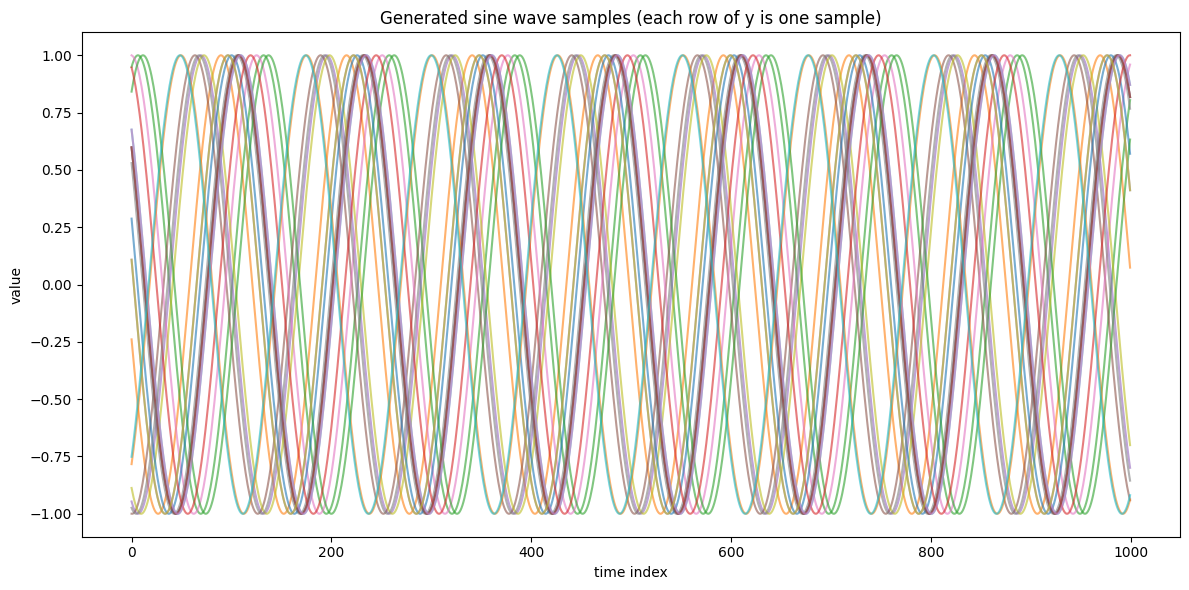

Training step: 0, Loss: 0.054482124745845795
Testing step: 0, Loss: 0.053669523447752


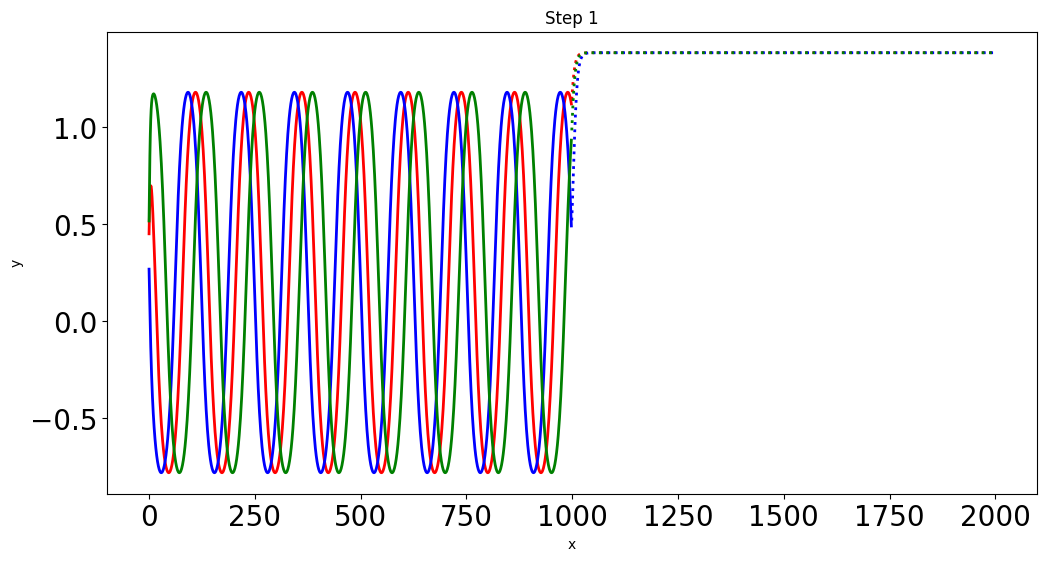

Training step: 1, Loss: 0.016247084364295006
Training loss change: -0.03823504038155079
Testing step: 1, Loss: 0.01589592546224594
Testing loss change: -0.03777359798550606


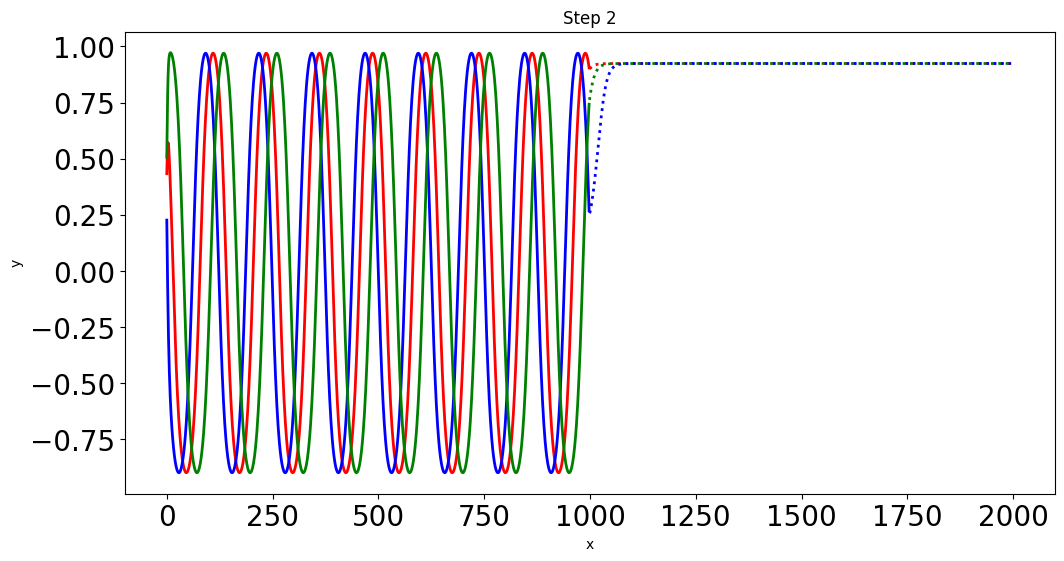

Training step: 2, Loss: 0.010802139528095722
Training loss change: -0.005444944836199284
Testing step: 2, Loss: 0.010523289442062378
Testing loss change: -0.005372636020183563


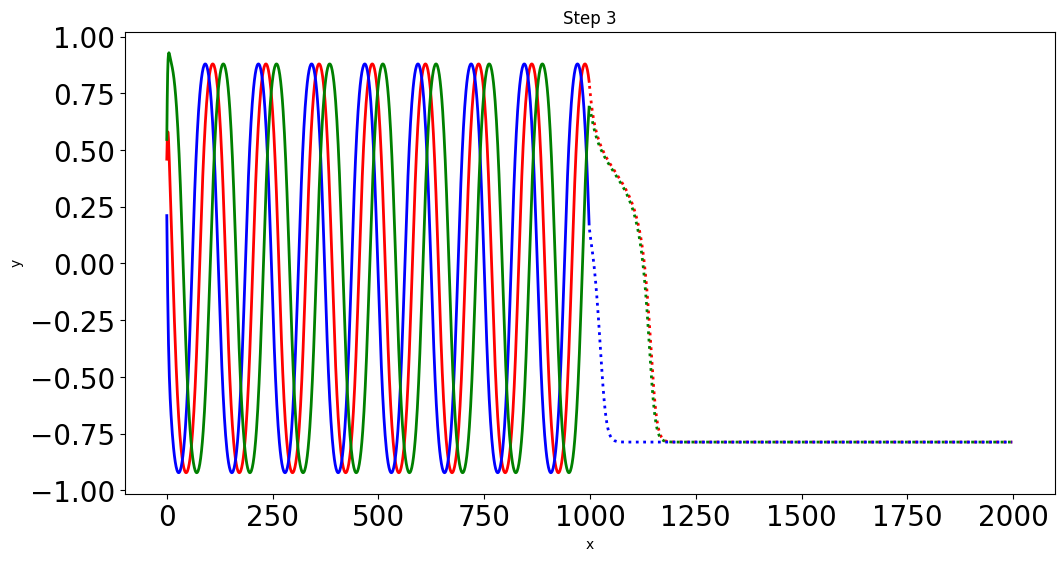

Training step: 3, Loss: 0.0020059163216501474
Training loss change: -0.008796223206445575
Testing step: 3, Loss: 0.0018518923316150904
Testing loss change: -0.008671397110447288


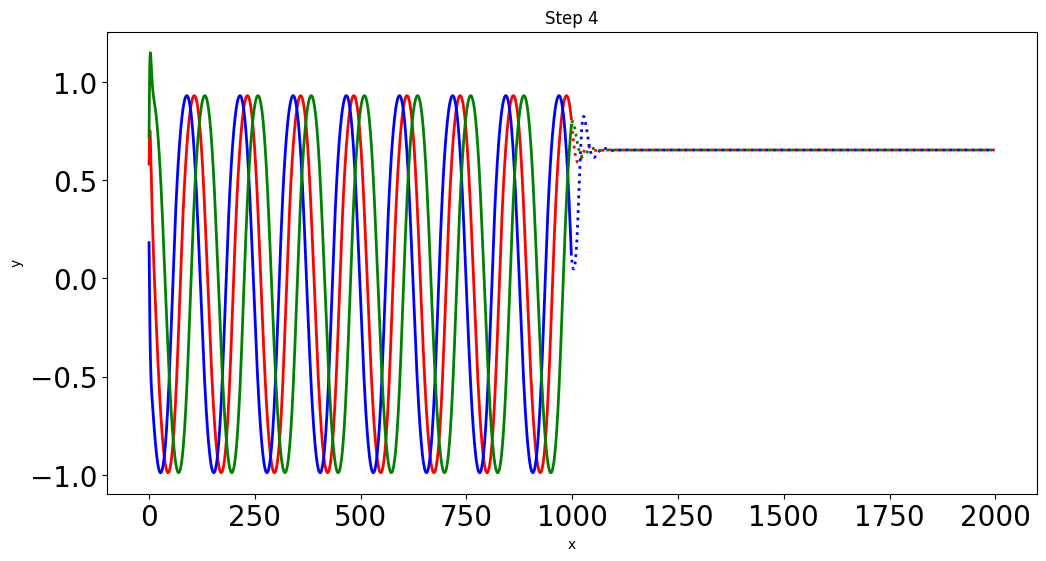

Training step: 4, Loss: 0.0008002038230188191
Training loss change: -0.0012057124986313283
Testing step: 4, Loss: 0.0006798941176384687
Testing loss change: -0.0011719982139766216


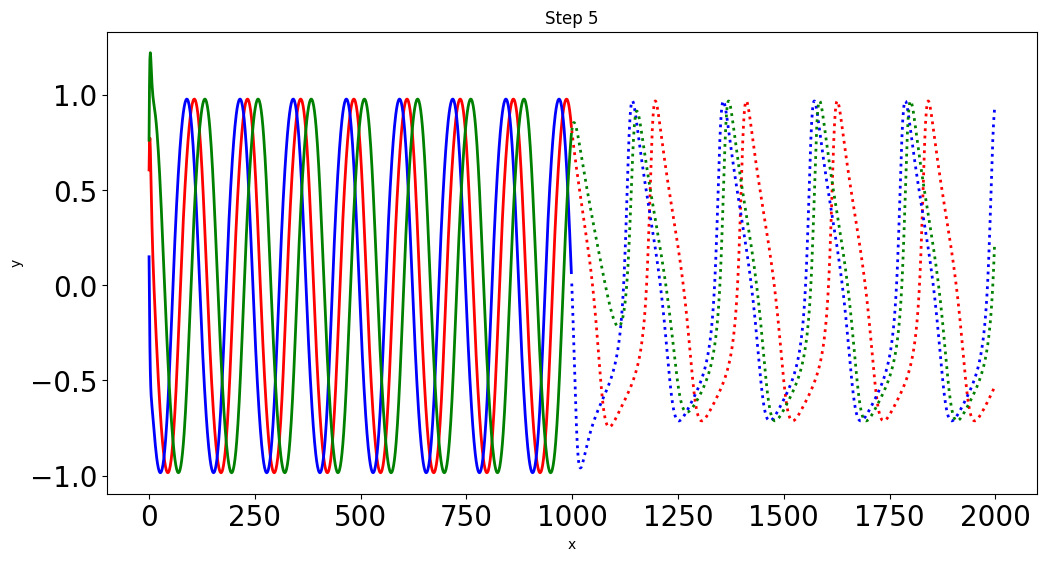

Training complete.


In [13]:
# Calling training loop
import torch.optim as optim
import torch.nn as nn
# Generate training and testing samples
train_input, train_target, test_input, test_target = geneate_training_and_testing_samples(
    sample_function=lambda: generate_sine_wave_samples(N=100, L=1000, T=20),
    sample_name="Generated sine wave",
    training_samples=3
)
# Initialize model and optimiser
model = LSTM()
optimiser = optim.LBFGS(model.parameters(), lr=0.08) # Using LBFGS optimiser instead of Adam
training_loop(n_epochs=5, model=model, optimiser=optimiser, loss_fn=nn.MSELoss(),
              train_input=train_input, train_target=train_target, test_input=test_input, test_target=test_target,
              future_preds=1000)